In [12]:
%pip install -q matplotlib

Note: you may need to restart the kernel to use updated packages.


In [1]:
import requests
import json
import random
import numpy as np
from datetime import datetime, timedelta
from pathlib import Path
from collections import defaultdict

## 1. Fetch Top Viewed Pages

Wikipedia's Pageviews API provides daily/monthly view counts.
We'll fetch the most viewed pages over the past month to get a good sample.

In [2]:
def fetch_top_pages(project="en.wikipedia", access="all-access", year=None, month=None, limit=1000):
    """
    Fetch top viewed Wikipedia pages for a given month.
    
    Uses the Wikimedia Pageviews API:
    https://wikimedia.org/api/rest_v1/
    """
    if year is None or month is None:
        # Default to last month
        last_month = datetime.now() - timedelta(days=30)
        year = last_month.year
        month = last_month.month
    
    url = f"https://wikimedia.org/api/rest_v1/metrics/pageviews/top/{project}/{access}/{year}/{month:02d}/all-days"
    
    headers = {
        "User-Agent": "Wiki3.ai OntologicalEngineer/0.1 (https://github.com/wiki3-ai/ontological-engineer)"
    }
    
    response = requests.get(url, headers=headers)
    response.raise_for_status()
    
    data = response.json()
    
    # Extract articles (skip special pages)
    articles = []
    for item in data["items"][0]["articles"]:
        title = item["article"]
        views = item["views"]
        
        # Skip special pages, main page, and disambiguation
        if title.startswith(("Special:", "Wikipedia:", "File:", "Template:", "Category:", "Portal:")):
            continue
        if title in ("Main_Page", "-"):
            continue
        if "(disambiguation)" in title:
            continue
            
        articles.append({
            "title": title.replace("_", " "),
            "title_normalized": title,
            "views": views,
        })
        
        if len(articles) >= limit:
            break
    
    return articles

# Fetch top pages
print("Fetching top viewed Wikipedia pages...")
top_pages = fetch_top_pages(limit=1000)
print(f"Retrieved {len(top_pages)} pages")

# Show top 10
print("\nTop 10 most viewed:")
for i, page in enumerate(top_pages[:10], 1):
    print(f"  {i}. {page['title']} ({page['views']:,} views)")

Fetching top viewed Wikipedia pages...
Retrieved 985 pages

Top 10 most viewed:
  1. Google Chrome (9,435,877 views)
  2. Zohran Mamdani (9,344,963 views)
  3. .xxx (7,154,093 views)
  4. Dharmendra (4,662,651 views)
  5. Deaths in 2025 (4,167,496 views)
  6. ChatGPT (3,639,485 views)
  7. Pluribus (TV series) (3,530,411 views)
  8. James A. Garfield (3,524,531 views)
  9. Rama Duwaji (3,129,745 views)
  10. Frankenstein (2025 film) (3,118,832 views)


## 2. Power-Law Sampling

We want to sample pages with a distribution similar to real access patterns:
- More popular pages are more likely to be selected
- But we still include some long-tail pages for diversity

This uses a power-law (Zipf-like) sampling approach.

In [3]:
def power_law_sample(pages, k=100, alpha=0.5, seed=42):
    """
    Sample pages with power-law weighted probability.
    
    Args:
        pages: List of page dicts with 'views' field
        k: Number of pages to sample
        alpha: Power-law exponent (0=uniform, 1=proportional to views)
               0.5 gives a nice balance
        seed: Random seed for reproducibility
    """
    random.seed(seed)
    np.random.seed(seed)
    
    # Compute weights based on views^alpha
    views = np.array([p["views"] for p in pages], dtype=float)
    weights = np.power(views, alpha)
    weights = weights / weights.sum()  # Normalize to probabilities
    
    # Sample without replacement
    indices = np.random.choice(
        len(pages), 
        size=min(k, len(pages)), 
        replace=False, 
        p=weights
    )
    
    sampled = [pages[i] for i in sorted(indices)]
    return sampled

# Sample 100 pages
K = 100
sampled_pages = power_law_sample(top_pages, k=K, alpha=0.5)

print(f"Sampled {len(sampled_pages)} pages with power-law distribution")
print(f"\nView count distribution in sample:")
views = [p['views'] for p in sampled_pages]
print(f"  Min: {min(views):,}")
print(f"  Max: {max(views):,}")
print(f"  Median: {np.median(views):,.0f}")
print(f"  Mean: {np.mean(views):,.0f}")

Sampled 100 pages with power-law distribution

View count distribution in sample:
  Min: 262,774
  Max: 9,344,963
  Median: 399,504
  Mean: 778,552


In [4]:
# Show the sampled pages
print("Sampled pages:")
print("=" * 60)
for i, page in enumerate(sampled_pages, 1):
    print(f"{i:3d}. {page['title'][:50]:<50} ({page['views']:>10,} views)")

Sampled pages:
  1. Zohran Mamdani                                     ( 9,344,963 views)
  2. ChatGPT                                            ( 3,639,485 views)
  3. James A. Garfield                                  ( 3,524,531 views)
  4. 1989 Tiananmen Square protests and massacre        ( 2,867,005 views)
  5. 2025 Bihar Legislative Assembly election           ( 2,555,071 views)
  6. Mira Nair                                          ( 2,503,516 views)
  7. Dick Cheney                                        ( 2,186,840 views)
  8. 2026 FIFA World Cup                                ( 2,155,565 views)
  9. 1xBet                                              ( 1,831,684 views)
 10. Survivor Series: WarGames (2025)                   ( 1,590,263 views)
 11. The Beast in Me (TV series)                        ( 1,533,565 views)
 12. Wicked (2024 film)                                 ( 1,319,838 views)
 13. The Running Man (2025 film)                        ( 1,298,779 views)
 14. One B

## 3. Exclude Albert Einstein (Few-Shot Source)

Albert Einstein is used for few-shot examples, so we exclude it from the training/eval set.

In [5]:
# Exclude pages we're using for few-shot
FEW_SHOT_PAGES = {"Albert Einstein"}

filtered_pages = [p for p in sampled_pages if p["title"] not in FEW_SHOT_PAGES]

if len(filtered_pages) < len(sampled_pages):
    print(f"Removed {len(sampled_pages) - len(filtered_pages)} few-shot pages")
else:
    print("No few-shot pages were in the sample")

print(f"Final sample: {len(filtered_pages)} pages")

No few-shot pages were in the sample
Final sample: 100 pages


## 4. Add Category Diversity (Optional)

Optionally fetch categories for each page to ensure topic diversity.

In [6]:
def fetch_page_categories(title, limit=5):
    """
    Fetch categories for a Wikipedia page.
    """
    url = "https://en.wikipedia.org/w/api.php"
    params = {
        "action": "query",
        "titles": title,
        "prop": "categories",
        "cllimit": limit,
        "clshow": "!hidden",
        "format": "json",
    }
    headers = {
        "User-Agent": "Wiki3.ai OntologicalEngineer/0.1"
    }
    
    try:
        response = requests.get(url, params=params, headers=headers, timeout=10)
        response.raise_for_status()
        data = response.json()
        
        pages = data.get("query", {}).get("pages", {})
        for page_id, page_data in pages.items():
            categories = page_data.get("categories", [])
            return [c["title"].replace("Category:", "") for c in categories]
    except Exception as e:
        print(f"  Warning: Could not fetch categories for {title}: {e}")
    
    return []

# Fetch categories for a subset to check diversity
print("Checking category diversity (first 20 pages)...")
category_counts = defaultdict(int)

for page in filtered_pages[:20]:
    cats = fetch_page_categories(page["title"])
    page["categories"] = cats
    for cat in cats:
        category_counts[cat] += 1

print(f"\nTop categories in sample:")
for cat, count in sorted(category_counts.items(), key=lambda x: -x[1])[:10]:
    print(f"  {cat}: {count}")

Checking category diversity (first 20 pages)...

Top categories in sample:
  2025 deaths: 3
  2020s American films: 3
  2020s English-language films: 3
  21st-century American women: 2
  2025 films: 2
  1991 births: 1
  21st-century American male musicians: 1
  21st-century Ugandan musicians: 1
  21st-century members of the New York State Legislature: 1
  American Muslim activists: 1


## 5. Save Sample

Save the sampled pages for use in training experiments.

In [7]:
# Prepare output
output = {
    "metadata": {
        "sampled_at": datetime.now().isoformat(),
        "source": "Wikipedia Pageviews API",
        "sample_size": len(filtered_pages),
        "sampling_method": "power_law",
        "alpha": 0.5,
        "seed": 42,
        "excluded_few_shot": list(FEW_SHOT_PAGES),
    },
    "pages": [
        {
            "title": p["title"],
            "title_normalized": p["title_normalized"],
            "views": p["views"],
            "url": f"https://en.wikipedia.org/wiki/{p['title_normalized']}",
        }
        for p in filtered_pages
    ]
}

# Save to file
output_dir = Path("/workspaces/wiki3-kg-project/data/training")
output_dir.mkdir(parents=True, exist_ok=True)

output_file = output_dir / "wikipedia_sample.json"
with open(output_file, "w") as f:
    json.dump(output, f, indent=2)

print(f"Saved {len(filtered_pages)} pages to {output_file}")

Saved 100 pages to /workspaces/wiki3-kg-project/data/training/wikipedia_sample.json


In [8]:
# Also save just the titles for quick reference
titles_file = output_dir / "wikipedia_sample_titles.txt"
with open(titles_file, "w") as f:
    for p in filtered_pages:
        f.write(p["title"] + "\n")

print(f"Saved titles to {titles_file}")
print("\nSample pages:")
for title in [p["title"] for p in filtered_pages[:20]]:
    print(f"  - {title}")
print(f"  ... and {len(filtered_pages) - 20} more")

Saved titles to /workspaces/wiki3-kg-project/data/training/wikipedia_sample_titles.txt

Sample pages:
  - Zohran Mamdani
  - ChatGPT
  - James A. Garfield
  - 1989 Tiananmen Square protests and massacre
  - 2025 Bihar Legislative Assembly election
  - Mira Nair
  - Dick Cheney
  - 2026 FIFA World Cup
  - 1xBet
  - Survivor Series: WarGames (2025)
  - The Beast in Me (TV series)
  - Wicked (2024 film)
  - The Running Man (2025 film)
  - One Battle After Another
  - Virginia Giuffre
  - SS Edmund Fitzgerald
  - Government shutdowns in the United States
  - Marjorie Taylor Greene
  - Charlie Kirk
  - Wikipedia
  ... and 80 more


## 6. Quick Stats

Summary statistics for the sample.

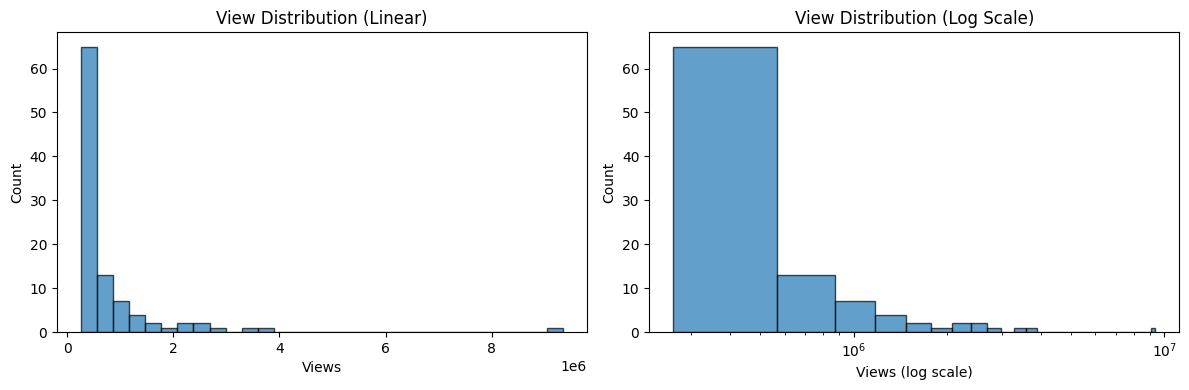


Sample Statistics:
  Total pages: 100
  Total views: 77,855,175
  Min views: 262,774
  Max views: 9,344,963
  Median views: 399,504
  Mean views: 778,552
  Std dev: 1,092,633


In [11]:
import matplotlib.pyplot as plt

# View distribution histogram
views = [p["views"] for p in filtered_pages]

fig, axes = plt.subplots(1, 2, figsize=(12, 4))

# Linear scale
axes[0].hist(views, bins=30, edgecolor='black', alpha=0.7)
axes[0].set_xlabel("Views")
axes[0].set_ylabel("Count")
axes[0].set_title("View Distribution (Linear)")

# Log scale
axes[1].hist(views, bins=30, edgecolor='black', alpha=0.7)
axes[1].set_xscale('log')
axes[1].set_xlabel("Views (log scale)")
axes[1].set_ylabel("Count")
axes[1].set_title("View Distribution (Log Scale)")

plt.tight_layout()
plt.show()

print(f"\nSample Statistics:")
print(f"  Total pages: {len(filtered_pages)}")
print(f"  Total views: {sum(views):,}")
print(f"  Min views: {min(views):,}")
print(f"  Max views: {max(views):,}")
print(f"  Median views: {np.median(views):,.0f}")
print(f"  Mean views: {np.mean(views):,.0f}")
print(f"  Std dev: {np.std(views):,.0f}")